In [1]:
import matplotlib.font_manager as fm

# fm.fontManager.addfont("./th_sarabun.ttf")

In [2]:
# fm.fontManager.ttflist

# Introduction

- Input ...
- Visualization

- get relevance scores
  - sensitivyt analysis
  - LRP Implementation

In [3]:
import sys
print(sys.path)
import sys
sys.path.append("../") 

['/Users/pat/projects/attacut/notebooks', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages', '/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/IPython/extensions', '/Users/pat/.ipython']


In [4]:
from attacut import Tokenizer, char_type

In [41]:
import numpy as np
import torch
import torch.nn.functional as F
from attacut import Tokenizer
from matplotlib import pyplot as plt


sc_cnn = "../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18"
sc_lstm = "../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12"
atta_sc_cnn = Tokenizer(model=sc_cnn)
atta_sc_lstm = Tokenizer(model=sc_lstm)

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction


In [42]:
sentence = "อำนาจตุลาการ คือจุดอ่อนของประชาธิปไตยไทย"

sentences = [
  sentence,
  "เวลาในความหมายของวิทยาศาสตร์",
  "ความแตกต่างอีกประการหนึ่งระหว่างไทยและอินเดีย",
  "เริ่ม~มี~ผู้~โทร~ศัพท์~ขอ~รับ~คำ~ปรึก~ษา~เนื่อง~จาก~เครียด".replace("~", ""),
  "แผน~ผัง~การ~ขยาย~พันธุ์~พืช~โดย~ย่อ~ๆ".replace("~", "")
]

In [43]:
atta_sc_cnn.tokenize(sentence)

torch.Size([1, 3, 40])


['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุดอ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [44]:
atta_sc_lstm.tokenize(sentence)

torch.Size([1, 3, 40])


['อำนาจ', 'ตุลาการ', ' ', 'คือ', 'จุด', 'อ่อน', 'ของ', 'ประชาธิปไตย', 'ไทย']

In [45]:
def word_boundary(model, sentence):
    words = model.tokenize(sentence)
    mask = np.zeros(len(sentence))

    cur_len = 0
    for w in words:
        mask[cur_len] = 1
        cur_len += len(w)
    return mask

word_boundary(atta_sc_cnn, sentence)

torch.Size([1, 3, 40])


array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [14]:
from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [16]:
class AttaCutSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        embedding = embedding.permute(0, 2, 1)

        out = self.base.model.id_conv(embedding)

        out = out.permute(0, 2, 1)
        out = F.relu(self.base.model.linear1(out))
        out = self.base.model.linear2(out)

        return out

In [17]:
def interpret_atta_sc(txt, wrapper_func):
    wrapper = wrapper_func()

    def ig_attac_forward(src, idx, pred):
        return torch.softmax(wrapper.forward(src), dim=2)[:, idx, pred]

    ig_c = IntegratedGradients(ig_attac_forward)

    tokens, features = wrapper.base.dataset.make_feature(txt)
    inputs = (features, torch.Tensor(0))

    x, _, _ = wrapper.base.dataset.prepare_model_inputs(inputs, device="cpu")

    wrapper.eval()
    wrapper.zero_grad()
    
    # pre-computing word embeddings
    interpretable_ch_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'ch_embeddings')
    src_ch_indices = torch.LongTensor(x[0][:, 0, :])
    src_ch_embedding = interpretable_ch_embedding.indices_to_embeddings(src_ch_indices)
    
    
    interpretable_ch_type_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'ch_type_embeddings')
    src_ch_t_indices = torch.LongTensor(x[0][:, 1, :])
    src_ch_t_embedding = interpretable_ch_type_embedding.indices_to_embeddings(src_ch_t_indices)
    
    
    interpretable_sy_embedding = configure_interpretable_embedding_layer(wrapper.base.model, 'sy_embeddings')
    src_sy_indices = torch.LongTensor(x[0][:, 2, :])
    src_sy_embedding = interpretable_sy_embedding.indices_to_embeddings(src_sy_indices)
    
    base_ch = interpretable_ch_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.ch_dict["<PAD>"])
    )
    
    base_ch_ty = interpretable_ch_type_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.ch_dict["<PAD>"])
    )
    
    base_sy = interpretable_sy_embedding.indices_to_embeddings(
        torch.tensor(wrapper.base.dataset.sy_dict["<PAD>"])
    )
    
    
    ch_dims = src_ch_embedding.shape[2] + src_ch_t_embedding.shape[2]

    embedding = torch.cat([src_ch_embedding, src_ch_t_embedding, src_sy_embedding], dim=2)
    dd = torch.cat([base_ch, base_ch_ty, base_sy]).repeat(1, len(tokens), 1)

    f_ref = torch.softmax(wrapper(dd), dim=2)
    
    outputs = wrapper(embedding).squeeze(0)

    attribution_igs = np.zeros((len(tokens), len(tokens), 2))

    for idx in range(len(tokens)):
        pred = np.argmax(outputs[idx, :].detach().numpy())
        f = torch.softmax(outputs[idx, :], dim=0)[pred].detach().numpy()

        attribution_ig =  ig_c.attribute(
            embedding, additional_forward_args=(idx, pred),
            n_steps=100,
            baselines=dd
        ).detach().numpy()

        attribution_ig = attribution_ig.squeeze()
        total_attribution = np.sum(attribution_ig)
        ch_attr, sy_attr = attribution_ig[:, :ch_dims], attribution_ig[:, ch_dims:]
        
        _f_ref = f_ref[0, idx][pred].detach().numpy()
        dff = f-_f_ref
        
        assert dff - total_attribution < 0.5, f"different attribution greater than 5e-1 ({dff-total_attribution})"

        attribution_igs[:, idx, 0] = np.sum(ch_attr, axis=1)
        attribution_igs[:, idx, 1] = np.sum(sy_attr, axis=1)

    return attribution_igs

raw_attribution = interpret_atta_sc(sentence, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)))

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding


/Users/pat/projects/attacut/venv/lib/python3.7/site-packages/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


torch.Size([1, 3, 28])
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
max relevance 0.6719556879043573


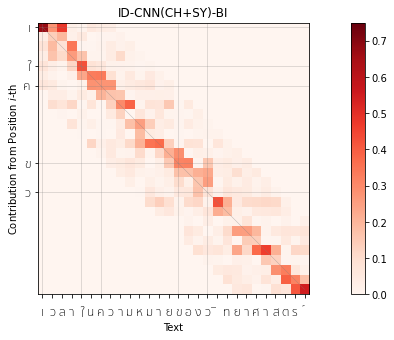

In [52]:
def plot_boundary(boundary):
    for i, b in enumerate(boundary):
        if b:
            plt.axvline(i, color="gray", lw=0.5, alpha=0.5)
            plt.axhline(i, color="gray", lw=0.5, alpha=0.5)

    plt.plot([0, i], [0, i], color="gray", lw=0.5, alpha=0.5)
    
def normalized_relevance(relevances):
    location_relevance = relevances.sum(axis=2)
        
    normalized_location_relevance = np.zeros((relevances.shape[0], relevances.shape[0]))
    
    for i in range(relevances.shape[0]):
        nn = np.abs(location_relevance[:, i])
        nn = nn / np.sum(nn)
        np.testing.assert_almost_equal(np.sum(nn), 1)
        normalized_location_relevance[:, i] = nn 
    return normalized_location_relevance
    

def plot_sc_relevances(sentence, model, wrapper_func, font="Sukhumvit Set", fontsize=12, name=""):
    boundary = word_boundary(model, sentence)

    relevances = interpret_atta_sc(sentence, wrapper_func)
    characters = list(sentence)

    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 1, 1)

    normalized_location_relevance = normalized_relevance(relevances)

    plot_boundary(boundary)
    print("max relevance", np.max(normalized_location_relevance))
    plt.imshow(normalized_location_relevance, cmap="Reds",
               vmin=0, vmax=0.75
              )
    plt.colorbar()

    plt.ylabel("Contribution from Position $i$-th")
    plt.title(name)
    ix = np.argwhere(boundary).reshape(-1)
    plt.yticks(ix, map(lambda i: characters[i],ix), fontname=font, fontsize=fontsize)
    plt.xticks(range(len(sentence)), list(sentence), fontname=font, fontsize=fontsize)
    plt.xlabel("Text")
    ax.tick_params(axis="x", pad=10, which='major',)
    


plot_sc_relevances(sentences[1], atta_sc_cnn, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)), name="ID-CNN(CH+SY)-BI")
plt.savefig("./figures/explained_cnn.png", dpi=300)

In [53]:
class AttaCutLSTMSCWrapper(torch.nn.Module):
    def __init__(self, tokenizer):
        super().__init__()
        self.base = tokenizer

    def forward(self, x):
        embedding = x

        out, _ = self.base.model.lstm(embedding)

        out = F.relu(self.base.model.linear1(out))
        out = self.base.model.linear2(out)

        return out

torch.Size([1, 3, 28])
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
max relevance 0.7152079622642886


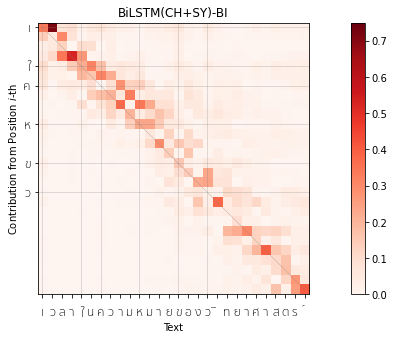

In [54]:
plot_sc_relevances(sentences[1], atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)-BI")
plt.savefig("./figures/explained_lstm.png", dpi=300)

In [ ]:
# for s in sentences:
#     plot_sc_relevances(s, atta_sc_lstm, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)), name="BiLSTM(CH+SY)")

# Compute Stats

In [28]:
with open("../data/best-test/input.txt") as fh:
    best_test = []
    for l in fh:
        l = l.strip()
        if 21 <= len(l) <= 50:
            best_test.append(l)

print(f"we have {len(best_test)}")

we have 338


In [29]:
def merge_dist(score, width=2):
    # score is symmetric metric
    
    dist = np.zeros(width*2+1)
    dist[width] = np.trace(score)
    for i in [-1, 1]:

        for j in range(1, width+1):
            offset = i*j
            dist[width+offset] = np.sum(np.diagonal(score, offset=offset))

    return dist


merge_dist(
    np.array(
        [
            [0.5, 0.3, 0.1, 0.0, 0.0, 0.0, 0.2],
            [0.1, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0],
            [0.1, 0.3, 0.8, 0.1, 0.1, 0.0, 0.0],
            [0.0, 0.3, 0.2, 0.3, 0.5, 0.1, 0.0],
            [0.0, 0.3, 0.2, 0.3, 0.5, 0.1, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.3, 0.5, 0.0],
            [0.0, 0.0, 0.2, 0.3, 0.1, 0.3, 0.8],
        ]
    ).T
)

array([0.4, 1.3, 3.7, 1.5, 1. ])

In [32]:
%%time
width = 20
def compute_dist(data, wrapper_func):
    dist = np.zeros(2*width+1)
    for i, sentence in enumerate(data):

        relevances = interpret_atta_sc(sentence, wrapper_func)

        relevances = np.abs(np.sum(relevances, axis=2))

        dist += merge_dist(relevances, width=width)
        if (i + 1) % 5 == 0:
            print("finished ", i)
    return dist
            
dist = compute_dist(best_test, lambda: AttaCutSCWrapper(Tokenizer(model=sc_cnn)))

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  4
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-0

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  64
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  124
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  129
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  189
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020

we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  249
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  254
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv

finished  309
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
finished  314
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv_3lv.yaml-2020-06-02--23-23.20/run-18
create new syllable embedding
we have 12969 syllables from ../artifact-server/seq_sy_ch_conv

In [33]:
dist

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,   46.07795443,   60.13867473,   73.0110645 ,
         47.05607034,  120.18070407,  152.85420939,  587.85139227,
       1102.14365529, 1099.10149097,  178.4102682 ,  181.7145286 ,
         76.13882623,   90.22306895,   55.21392481,   54.8099908 ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ])

In [34]:
np.save("dist_cnn", dist)

In [55]:
%%time
dist_lstm = compute_dist(best_test, lambda: AttaCutLSTMSCWrapper(Tokenizer(model=sc_lstm)))

we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  4
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-ser

we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  69
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  74
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from .

we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  139
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  144
we have 12969 syllables from

finished  204
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  209
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from

we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  274
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
finished  279
we have 12969 syllables from ../artifact-server/seq_sy_ch_lstm_bi.yaml-2020-06-03--20-26.20/run-12
using bi-direction
we have 12969 syllables from

In [56]:
dist_lstm

array([  4.4529521 ,   5.65843603,   6.5226619 ,   8.37257751,
         9.70971262,  10.99447612,  13.13398947,  15.40195475,
        18.08105229,  20.30849049,  23.47450252,  29.65771526,
        35.24726559,  46.93837134,  56.85319079,  78.64348035,
       114.13091418, 149.84761953, 303.53115501, 519.66404122,
       867.29566059, 958.70158404, 491.24777085, 254.32562612,
       161.4808755 , 116.14595501,  89.16554435,  74.36341726,
        63.47973375,  55.06880791,  47.2009448 ,  42.20450699,
        40.36637283,  38.29343963,  35.95715184,  35.48020404,
        32.44218202,  31.695332  ,  31.79662521,  28.72164233,
        27.35550883])

In [57]:
np.save("dist_lstm", dist_lstm)

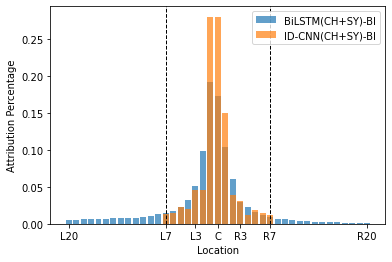

In [59]:
x = list(range(dist.shape[0]))
alpha = 0.7
conf_filter_width = 7 

dist_lr = dist[::-1]
dist_lstm_lr = dist_lstm[::-1]


plt.bar(x, dist_lstm_lr/np.sum(dist_lstm_lr), label="BiLSTM(CH+SY)-BI", alpha=alpha)
plt.bar(x, dist_lr/np.sum(dist_lr), label="ID-CNN(CH+SY)-BI", alpha=alpha)
plt.xticks(
    [0, width-conf_filter_width, width-3, width, width+3, width+conf_filter_width, 2*width],
    [f"L{width}", "L7", "L3", "C", "R3", "R7", f"R{width}"]);
plt.axvline(width-conf_filter_width, lw=1, ls="--", color="black")
plt.axvline(width+conf_filter_width, lw=1, ls="--", color="black")
plt.legend();
plt.ylabel("Attribution Percentage")
plt.xlabel("Location")
plt.savefig("./figures/attribution-dist.png", dpi=300)

In [ ]:
dist_lstm_loaded = np.load("./dist_lstm.npy")

In [ ]:
dist_lstm_loaded